In [2]:
!unzip /content/TXL-PBC_Classification_Resampled.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/b40ffdb28cf45ccd8e61e28debf6cebe_7.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/641e132ec17057e3a0dc8b5dfbe68c10_14.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/6970813f80fa575c821dc7d1455f871f_3.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/d4401a6fff2851c1abf16fd98cb93142_4.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/4035a5a2200957158817dd89483287c4_1.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/4d967f92175d52f48022ce8bc2ca0f24_8.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)/e46e21553f6d542e96daeed3fdd9b646_7.jpg  
  inflating: content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RB

In [3]:
!find /content/content/TXL-PBC_Classification_Resampled -maxdepth 3 -type d -print


/content/content/TXL-PBC_Classification_Resampled
/content/content/TXL-PBC_Classification_Resampled/train
/content/content/TXL-PBC_Classification_Resampled/train/0 White Blood Cell (WBC)
/content/content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC)
/content/content/TXL-PBC_Classification_Resampled/train/2 Platelet
/content/content/TXL-PBC_Classification_Resampled/test
/content/content/TXL-PBC_Classification_Resampled/test/0 White Blood Cell (WBC)
/content/content/TXL-PBC_Classification_Resampled/test/1 Red Blood Cell (RBC)
/content/content/TXL-PBC_Classification_Resampled/test/2 Platelet
/content/content/TXL-PBC_Classification_Resampled/val
/content/content/TXL-PBC_Classification_Resampled/val/0 White Blood Cell (WBC)
/content/content/TXL-PBC_Classification_Resampled/val/1 Red Blood Cell (RBC)
/content/content/TXL-PBC_Classification_Resampled/val/2 Platelet


In [4]:
!pip install albumentations tqdm


In [8]:
import albumentations as A
import cv2
import numpy as np

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),

    A.Affine(
        scale=(0.8, 1.2),
        translate_percent=(0.05, 0.05),
        rotate=(-20, 20),
        shear=(-10, 10),
        mode=cv2.BORDER_REFLECT_101,
        p=0.7
    ),

    A.RandomBrightnessContrast(p=0.7),
    A.GaussNoise(p=0.4),
    A.HueSaturationValue(p=0.4),
])


/tmp/ipython-input-3216056322.py:11: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(


In [9]:
import os
from tqdm import tqdm

def augment_class_folder(class_folder, target_count):
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(("jpg","png","jpeg"))]

    current = len(images)
    needed = target_count - current
    if needed <= 0:
        print(f"[OK] {class_folder} already balanced ({current})")
        return

    print(f"[AUGMENTING] {class_folder} → Need {needed} images")

    idx = 0
    while idx < needed:
        img_name = np.random.choice(images)
        img_path = os.path.join(class_folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented = augment(image=img)["image"]

        out_name = f"aug_{idx}_{img_name}"
        out_path = os.path.join(class_folder, out_name)

        cv2.imwrite(out_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        idx += 1

    print(f"[DONE] Created {needed} new images in {class_folder}")


In [10]:
def balance_split(split_path):
    classes = [
        "0 White Blood Cell (WBC)",
        "1 Red Blood Cell (RBC)",
        "2 Platelet"
    ]

    print(f"\n=== Balancing {split_path} ===")

    # Count samples in each class
    counts = {}
    for cls in classes:
        folder = os.path.join(split_path, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(("jpg","png","jpeg"))])
        counts[cls] = count
        print(f"{cls}: {count}")

    # target = max count in this split
    target_count = max(counts.values())
    print(f"→ Target per class for {split_path}: {target_count}")

    # Augment each class to match target
    for cls in classes:
        folder = os.path.join(split_path, cls)
        augment_class_folder(folder, target_count)


In [11]:
root = "/content/content/TXL-PBC_Classification_Resampled"

balance_split(os.path.join(root, "train"))
balance_split(os.path.join(root, "val"))
balance_split(os.path.join(root, "test"))



=== Balancing /content/content/TXL-PBC_Classification_Resampled/train ===
0 White Blood Cell (WBC): 908
1 Red Blood Cell (RBC): 11411
2 Platelet: 376
→ Target per class for /content/content/TXL-PBC_Classification_Resampled/train: 11411
[AUGMENTING] /content/content/TXL-PBC_Classification_Resampled/train/0 White Blood Cell (WBC) → Need 10503 images
[DONE] Created 10503 new images in /content/content/TXL-PBC_Classification_Resampled/train/0 White Blood Cell (WBC)
[OK] /content/content/TXL-PBC_Classification_Resampled/train/1 Red Blood Cell (RBC) already balanced (11411)
[AUGMENTING] /content/content/TXL-PBC_Classification_Resampled/train/2 Platelet → Need 11035 images
[DONE] Created 11035 new images in /content/content/TXL-PBC_Classification_Resampled/train/2 Platelet

=== Balancing /content/content/TXL-PBC_Classification_Resampled/val ===
0 White Blood Cell (WBC): 259
1 Red Blood Cell (RBC): 3260
2 Platelet: 107
→ Target per class for /content/content/TXL-PBC_Classification_Resampled/v

In [12]:
import os
from pathlib import Path

BASE = Path("/content/content/TXL-PBC_Classification_Resampled")

splits = ["train", "val", "test"]

dataset_counts = {}

for split in splits:
    split_dir = BASE / split
    class_counts = {}

    for class_folder in sorted(os.listdir(split_dir)):
        class_path = split_dir / class_folder
        if class_path.is_dir():
            num_images = len([f for f in os.listdir(class_path)
                              if f.lower().endswith((".jpg", ".jpeg", ".png"))])
            class_counts[class_folder] = num_images

    dataset_counts[split] = class_counts

# Print results
for split, counts in dataset_counts.items():
    print(f"\n====== {split.upper()} ======")
    for cls, num in counts.items():
        print(f"{cls}: {num}")
    print("------------------------------")
    print("TOTAL:", sum(counts.values()))



====== TRAIN ======
0 White Blood Cell (WBC): 11411
1 Red Blood Cell (RBC): 11411
2 Platelet: 11411
------------------------------
TOTAL: 34233

====== VAL ======
0 White Blood Cell (WBC): 3260
1 Red Blood Cell (RBC): 3260
2 Platelet: 3260
------------------------------
TOTAL: 9780

====== TEST ======
0 White Blood Cell (WBC): 1631
1 Red Blood Cell (RBC): 1631
2 Platelet: 1631
------------------------------
TOTAL: 4893


In [13]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

BASE = Path("/content/content/TXL-PBC_Classification_Resampled")

splits = ["train", "val", "test"]
dataset_counts = {}

for split in splits:
    split_dir = BASE / split
    class_counts = {}

    for class_folder in sorted(os.listdir(split_dir)):
        class_path = split_dir / class_folder
        if class_path.is_dir():
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])
            class_counts[class_folder] = num_images

    dataset_counts[split] = class_counts


In [14]:
for split, counts in dataset_counts.items():
    print(f"\n====== {split.upper()} ======")
    for cls, num in counts.items():
        print(f"{cls}: {num}")
    print("------------------------------")
    print("TOTAL:", sum(counts.values()))



====== TRAIN ======
0 White Blood Cell (WBC): 11411
1 Red Blood Cell (RBC): 11411
2 Platelet: 11411
------------------------------
TOTAL: 34233

====== VAL ======
0 White Blood Cell (WBC): 3260
1 Red Blood Cell (RBC): 3260
2 Platelet: 3260
------------------------------
TOTAL: 9780

====== TEST ======
0 White Blood Cell (WBC): 1631
1 Red Blood Cell (RBC): 1631
2 Platelet: 1631
------------------------------
TOTAL: 4893


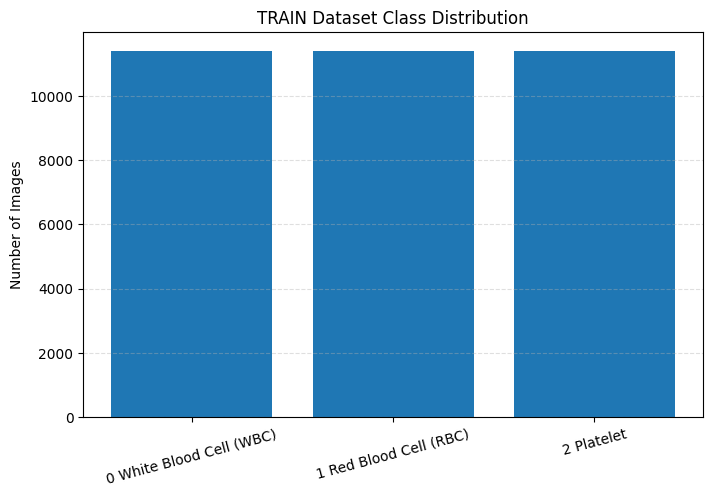

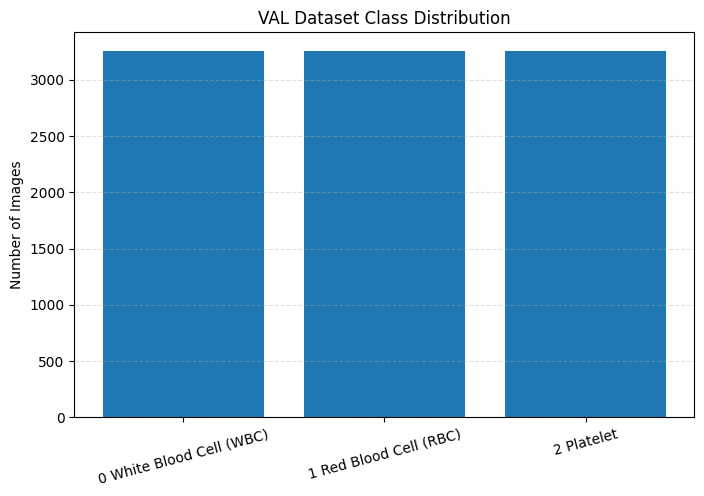

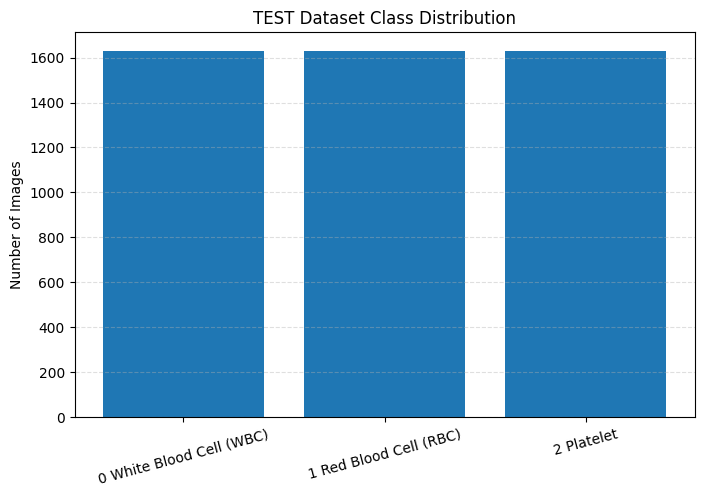

In [15]:
for split, counts in dataset_counts.items():
    plt.figure(figsize=(8,5))
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{split.upper()} Dataset Class Distribution")
    plt.xticks(rotation=15)
    plt.ylabel("Number of Images")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()


In [16]:
import shutil
from pathlib import Path

# Source: your augmented dataset
source_folder = Path("/content/content/TXL-PBC_Classification_Resampled")

# Target folder (new saved dataset)
save_folder = Path("/content/TXL-PBC_Classification_Balanced")
save_folder.mkdir(exist_ok=True)

# Copy all contents
shutil.copytree(source_folder, save_folder, dirs_exist_ok=True)
print(f"Dataset copied to: {save_folder}")


Dataset copied to: /content/TXL-PBC_Classification_Balanced


In [17]:
import shutil

zip_file = "/content/TXL-PBC_Classification_Balanced.zip"
shutil.make_archive("/content/TXL-PBC_Classification_Balanced", 'zip', root_dir=save_folder)
print(f"Dataset zipped: {zip_file}")


Dataset zipped: /content/TXL-PBC_Classification_Balanced.zip


In [18]:
from google.colab import files

files.download('/content/TXL-PBC_Classification_Balanced.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# === Common Setup (Run Once) ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from pathlib import Path
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT = Path("/content/TXL-PBC_Classification_Balanced")

class ImagePathDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.transform = transform
        self.samples = []
        self.classes = sorted([c.name for c in (root_dir / split).iterdir() if c.is_dir()])
        self.class_to_idx = {cls:i for i,cls in enumerate(self.classes)}
        for cls in self.classes:
            for img_path in (root_dir / split / cls).glob("*"):
                if img_path.suffix.lower() in [".jpg",".png",".jpeg"]:
                    self.samples.append((str(img_path), self.class_to_idx[cls]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Model builder
def build_model(name, num_classes):
    if name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet34":
        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b3":
        model = models.efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "convnext_tiny":
        model = models.convnext_tiny(pretrained=True)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif name == "vit_b_16":
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif name == "inception_v3":
        model = models.inception_v3(pretrained=True, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unknown model name:", name)
    return model.to(device)


Device: cpu


In [ ]:
# === Training Cell ===
MODEL_NAME = "resnet18"  # Change per cell
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
PATIENCE = 3

# Load datasets
train_dataset = ImagePathDataset(DATA_ROOT, split="train", transform=train_transform)
val_dataset = ImagePathDataset(DATA_ROOT, split="val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = build_model(MODEL_NAME, num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

best_val_acc = 0
counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for imgs, labels in tqdm(train_loader, desc=f"{MODEL_NAME} Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_acc = correct/total
    train_loss = total_loss/len(train_loader)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_acc = correct/total
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{MODEL_NAME}_best.pth")
        counter = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Training finished. Best val accuracy: {best_val_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]
resnet18 Epoch 1/10: 100%|██████████| 1070/1070 [2:11:32<00:00,  7.38s/it]


Epoch 1: Train Loss=0.0432, Train Acc=0.9857, Val Acc=0.9974


resnet18 Epoch 2/10: 100%|██████████| 1070/1070 [2:12:52<00:00,  7.45s/it]


Epoch 2: Train Loss=0.0176, Train Acc=0.9945, Val Acc=0.9984


resnet18 Epoch 3/10:  16%|█▌        | 173/1070 [21:35<1:51:30,  7.46s/it]